# Linear regression model with variance based feature selection

In [8]:
# import necessary packages

# Plot the figures inline, necessary only for Jupyter notebook
%matplotlib inline 

import os # miscelleaneous operating system interface
import numpy as np  # import numpy
import pandas as pd # import pandas
import matplotlib.pyplot as plt 
import seaborn as sns # import seaborn for data visualization

from sklearn.linear_model import LinearRegression 
from sklearn.metrics import root_mean_squared_error as RMSE # calculate RMSE
from sklearn.pipeline import Pipeline # may need it later for feature engineering
from sklearn.model_selection import train_test_split # splitting data into training and testing set

In [9]:
# import the data set for drugs

df_drug=pd.read_csv('GDSC2_label_14drugs.csv') # load the data set for drugs (limited to 14 drugs)
df_drug.set_index('Unnamed: 0', inplace=True)

print(df_drug.shape) # shape for drug data

# Result: 805 tumor cells (cell lines) and 14 drugs
# df_drug.head(5) # print the first 5 instances to have a look

# We only focus on the 3 drugs with largest variances in their efficacies among different drugs
drug_sort=df_drug.std().sort_values(ascending = False).iloc[0:3]

# import the data set for tumor cells (cell lines) and genes

df_tumor=pd.read_csv('GDSC2_expression14.csv') # load the data set for tumors and cell lines
df_tumor.set_index('Unnamed: 0', inplace=True)
gene=list(df_tumor.columns)

# print('Number of genes:', len(gene))
# print('First gene: ',gene[0])

print('Shape of data frame', df_tumor.shape) # shape for tumor data
# df_tumor.iloc[0:5, 0:10] # print the first 5 instances to have a look, only print the first 10 columns

# Result: 805 tumor cells (instances) and 17419 genes (features)

(805, 14)
Shape of data frame (805, 17419)


In [10]:
# The 3 drugs with the largest variances among all 805 tumors
# See EDA and overfitting notebook

drug1=drug_sort.index[0] # 'Docetaxel'
drug2=drug_sort.index[1] # 'Trametinib'
drug3=drug_sort.index[2] # 'Entinostat'

# Merge the two data set together WITHOUT any selection of features
# We do not need to save too many decimal places, keep 2 decimal places is fine
# The last column becomes the drug efficacy

df_1=pd.concat([df_tumor, df_drug[drug1].round(2)], axis=1) # axis=1 because we join the columns, not rows
df_2=pd.concat([df_tumor, df_drug[drug2].round(2)], axis=1) 
df_3=pd.concat([df_tumor, df_drug[drug3].round(2)], axis=1) 

# print(df_1.shape)
# df_1.head(5)

# Linear regression model with 100 most variate genes

In [11]:
# Calculate variance for each gene across the 805 samples
# Select the 50 genes with highest variance (after normalization)

from sklearn.preprocessing import normalize # normalize the columns for the genes

n=50 # number of genes to keep

df_tumor_norm=pd.DataFrame(normalize(df_tumor, axis=0)) # result after normalization is a numpy array, we need data frame
df_tumor_norm.columns=gene # assign the gene name as column names

# calculate the variance for each gene type across 805 samples and sort the results
df_tumor_var=pd.DataFrame(df_tumor_norm.var())
df_tumor_var.columns=['normed var']

# Comments: There are many genes having small variances across different types of tumor cells. 
# Again, doesn't mean that they have no importance in drug efficacy!

# Picking the 100 genes with the largest variances across all tumor types

df_var=df_tumor_var.sort_values('normed var',ascending = False).iloc[0:n,:]
df_var.index # This list stores the names of that 100 genes
# df_var

Index(['RPS4Y1', 'HLA-DRA', 'ITM2A', 'MIR205HG', 'TACSTD2', 'SPP1', 'TSPAN8',
       'LAPTM5', 'TFF1', 'GMFG', 'COL1A2', 'KRT6A', 'LUM', 'S100A9', 'BEX1',
       'SRGN', 'CD53', 'IGJ', 'POU2AF1', 'S100A14', 'TFF3', 'S100P', 'GTSF1',
       'AKR1B10P1', 'COL3A1', 'C8orf4', 'UCA1', 'INSM1', 'GPX2', 'LCN2',
       'CEACAM5', 'MMP7', 'PCP4', 'CD52', 'LYZ', 'AKR1C2', 'FGFBP1', 'GRP',
       'PHGR1', 'MMP1', 'SCG2', 'RAB25', 'CXCR4', 'COL6A3', 'KRT5', 'POSTN',
       'BCL2A1', 'INHBB', 'CCL2', 'ANXA10'],
      dtype='object')

In [12]:
# Using the selected genes from variance-based slection
# Simple linear regression model on Docetaxel, Trametinib, Entinostat

# 20% of the data is used as test set, meaning 161 cell lines are saved for the test set
df_train_1, df_test_1 = train_test_split(df_1, shuffle=True, random_state=42, test_size=.2)
df_train_2, df_test_2 = train_test_split(df_2, shuffle=True, random_state=42, test_size=.2)
df_train_3, df_test_3 = train_test_split(df_3, shuffle=True, random_state=42, test_size=.2)

lin_reg_1 = LinearRegression()
lin_reg_2 = LinearRegression()
lin_reg_3 = LinearRegression()

lin_reg_1.fit(df_train_1[df_var.index], df_train_1.iloc[:,-1:])
lin_reg_2.fit(df_train_2[df_var.index], df_train_2.iloc[:,-1:])
lin_reg_3.fit(df_train_3[df_var.index], df_train_3.iloc[:,-1:])

# The resuls: y_0 + y_coeff dot (genes)
# y_0, y_coeff = lin_reg.intercept_, lin_reg.coef_

# Calculate the RMSE
ytrain_1 = lin_reg_1.predict(df_train_1[df_var.index])
ytrain_2 = lin_reg_2.predict(df_train_2[df_var.index])
ytrain_3 = lin_reg_3.predict(df_train_3[df_var.index])
train_lin_rmse_1 = RMSE(df_train_1.iloc[:,-1:], ytrain_1)
train_lin_rmse_2 = RMSE(df_train_2.iloc[:,-1:], ytrain_2)
train_lin_rmse_3 = RMSE(df_train_3.iloc[:,-1:], ytrain_3)

ytest_1 = lin_reg_1.predict(df_test_1[df_var.index])
ytest_2 = lin_reg_2.predict(df_test_2[df_var.index])
ytest_3 = lin_reg_3.predict(df_test_3[df_var.index])
test_lin_rmse_1 = RMSE(df_test_1.iloc[:,-1:], ytest_1)
test_lin_rmse_2 = RMSE(df_test_2.iloc[:,-1:], ytest_2)
test_lin_rmse_3 = RMSE(df_test_3.iloc[:,-1:], ytest_3)

# Take square root for the MSE obtained from Scikit-Learn

print (f"RMSE for the training set for {drug1}", np.round(train_lin_rmse_1,3))
print (f"RMSE for the test set for {drug1}", np.round(test_lin_rmse_1,3))
print(f"sd in efficacy of {drug1}", df_1[drug1].std().round(3))
print("\n")

print (f"RMSE for the training set for {drug2}", np.round(train_lin_rmse_2,3))
print (f"RMSE for the test set for {drug2}", np.round(test_lin_rmse_2,3))
print(f"sd in efficacy of {drug2}", df_2[drug2].std().round(3))
print("\n")

print (f"RMSE for the training set for {drug3}", np.round(train_lin_rmse_3,3))
print (f"RMSE for the test set for {drug3}", np.round(test_lin_rmse_3,3))
print(f"sd in efficacy of {drug3}", df_3[drug3].std().round(3))

# The RMSE for training and testing sets are now closer. No overfitting
# We still need to see if our model underfits, so compare to sd of drug efficacy 

# Very close or even larger than the the SD, not a good model...

RMSE for the training set for Docetaxel 0.171
RMSE for the test set for Docetaxel 0.175
sd in efficacy of Docetaxel 0.192


RMSE for the training set for Trametinib 0.143
RMSE for the test set for Trametinib 0.196
sd in efficacy of Trametinib 0.186


RMSE for the training set for Entinostat 0.087
RMSE for the test set for Entinostat 0.106
sd in efficacy of Entinostat 0.105


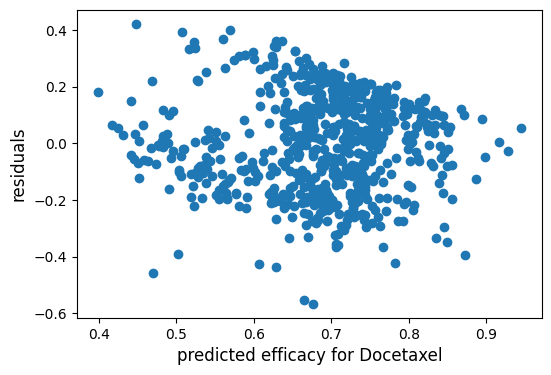

In [13]:
# Checking assumptions of linear regression satisfied: Residual plot and Homoscedasticity
# If the linear model is a good approximation, the residual plot should behave as a gaussian noise

# Here, the residual plot is for having 100 features selected from variance based approach
residuals_var = df_train_1.iloc[:,-1:] - ytrain_1

plt.figure(figsize=(6,4))
plt.scatter(ytrain_1, residuals_var)
plt.xlabel(f"predicted efficacy for {drug1}", fontsize=12)
plt.ylabel("residuals", fontsize=12)
plt.show()

# Clearly, not Gaussian noise. Heteroscedasticity --> Linear regression model is inappropriate. 
# Also, the RMSE for test set is even bigger than the standard deviation of the data.